<a href="https://colab.research.google.com/github/SiliconAlchemist/Learned_Stable_Bloom_Filters/blob/main/CLDS_Project_Training_Models_%5BWeb_Caching%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tldextract
!pip install mmh3

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import tldextract
from ipaddress import ip_address
import seaborn as sns
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
! cd /content/drive/MyDrive/CLDS_Shortcut/CLDS/Dataset/Web\ Caching && ls
#! cd /content/drive/MyDrive/Sem\ 8/CLDS/Dataset/Web\ Caching && ls

cached_urls.txt


In [5]:
root = "/content/drive/MyDrive/CLDS_Shortcut/CLDS/Dataset/Web Caching/"
#root = "/content/drive/MyDrive/Sem 8/CLDS/Dataset/Web Caching/"
file_name = "cached_urls.txt"

In [6]:
with open(root+file_name, encoding="ISO-8859-1") as f:
    urls = f.readlines()

In [7]:
cleaned_urls = [l.split('www.')[-1] for l in urls]
cleaned_urls = cleaned_urls[:50000]

In [8]:
random.shuffle(cleaned_urls)

cached_urls = cleaned_urls[:len(cleaned_urls)//4]
non_cached_urls = cleaned_urls[len(cleaned_urls)//4:]
 
len(cached_urls), len(non_cached_urls), len(cached_urls) + len(non_cached_urls), len(cleaned_urls)

(12500, 37500, 50000, 50000)

### Feature Selection
1. Length of URL
2. No. of Dots
3. Presence of Hyphen
4. Presence of Double Slashes
5. Presence of @ Symbol
6. Presence of IP Address

In [9]:
length_url = []
labels = []
num_dots = []
num_hyphen = []
num_double_slashes = []
num_at = []
bool_ip_addr = []
url_strs=[]

def generate_features(url, label):
  length_url.append(len(url))
  num_dots.append(url.count('.'))
  num_hyphen.append(url.count('-'))
  num_double_slashes.append(url.count('//'))
  num_at.append(url.count('@'))
  url_strs.append(url)
  
  try:
    tldextract.extract(url).domain
    bool_ip_addr.append(1)
  except:
    bool_ip_addr.append(0)

  labels.append(label)

In [10]:
for url in cached_urls:
  generate_features(url, 1)

for url in non_cached_urls:
  generate_features(url, 0)

In [11]:
len(length_url), len(labels), len(num_dots), len(num_hyphen), len(num_double_slashes), len(num_at), len(bool_ip_addr), len(url_strs)

(50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000)

In [12]:
final_data = np.array(np.vstack((url_strs,length_url, num_dots, num_hyphen, num_double_slashes, num_at, bool_ip_addr, labels))).T

In [13]:
random.shuffle(final_data)

In [14]:
final_data[:,7]

array(['1', '1', '1', ..., '0', '0', '0'], dtype='<U2308')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [16]:
x_train_complete, x_test_complete, y_train, y_test = train_test_split(final_data[:,:7], final_data[:,7], test_size = 0.9, random_state = 42)

In [17]:
x_train_complete[:,1:7]

array([['65', '2', '0', '0', '0', '1'],
       ['60', '3', '0', '0', '1', '1'],
       ['197', '3', '2', '0', '1', '1'],
       ...,
       ['115', '1', '1', '0', '0', '1'],
       ['47', '2', '0', '0', '0', '1'],
       ['35', '2', '0', '0', '0', '1']], dtype='<U2308')

In [18]:
x_train_url_strs=x_train_complete[:,0]
x_train=x_train_complete[:,1:7].astype('float')
y_train=y_train.astype('float')
x_test_url_strs=x_test_complete[:,0]
x_test=x_test_complete[:,1:7].astype('float')
y_test=y_test.astype('float')

In [19]:
np.unique(y_train,return_counts=True), np.unique(y_test,return_counts=True)

((array([0., 1.]), array([2020, 2980])),
 (array([0., 1.]), array([18033, 26967])))

In [20]:
len(x_train), len(x_test), len(y_train), len(y_test)

(5000, 45000, 5000, 45000)

In [21]:
models = { "Gaussian Naive Bayes":GaussianNB(),
         "Logistic Regression":LogisticRegression(),
          "Support Vector Machines": svm.SVC()   
}

In [22]:
results = {}
for algo in models:
    clf = models[algo]
    clf.fit(x_train,y_train)
    score = clf.score(x_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

Gaussian Naive Bayes : 0.5890666666666666 
Logistic Regression : 0.5992666666666666 
Support Vector Machines : 0.5992666666666666 


In [23]:
results = {}
for algo in models:
  clf = models[algo]
  res = clf.predict(x_test)
  mt = confusion_matrix(y_test, res)
  print(algo)
  print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
  print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

Gaussian Naive Bayes
False positive rate : 95.630233 %
False negative rate : 4.624170 %
Logistic Regression
False positive rate : 100.000000 %
False negative rate : 0.000000 %
Support Vector Machines
False positive rate : 100.000000 %
False negative rate : 0.000000 %


In [24]:
import mmh3
from random import sample


class stable_bloom_filter(object):
    
    def __init__(self,m,Mx,K):
        '''
        m: Number of Cells in the bloom filter
        Mx: Maximum value a cell can hold
        K: Number of Hash Functions
        
        Initialises a stable bloom filter
        ''' 
        self.m=m
        self.Mx=Mx
        self.K=K
        
        #calculating other parameters.
        self.P=256
        self.filter=[0]*self.m
        
    def is_duplicate(self,item):
        '''
        item: input item
        
        returns if the input item is already contained within the filter
        '''
        flag=True
        hashes=self.get_hashes(item)
        for i in range(self.K):
            if(self.filter[hashes[i]]==0):
                flag=False

        self.remove_random_elements()
        self.add_element(hashes)
        return flag
    
    def add_element(self,hashes):
        '''
        hashes: keys by K hash functions
        Adds an element to the filter by setting all the hash cells to max
        '''
        for i in range(self.K):
            self.filter[hashes[i]]=self.Mx
        
    
    def remove_random_elements(self):
        '''
        Decrement random P cells by 1.
        '''
        cell_ind=[i for i in range(self.m)]
        rem_ind=sample(cell_ind,self.P)
        for i in rem_ind:
            self.filter[i]=max(0,self.filter[i]-1)
    
    def get_hashes(self,item):
        '''
        item: input item
        
        returns K hashes derived from k independent hash functions
        '''
        hashes = []
        
        for i in range(self.K):
            hash_val = mmh3.hash(item, i) % self.m
            hashes.append(hash_val)
        
        return hashes

In [25]:
y_train

array([1., 1., 1., ..., 0., 1., 0.])

## FNR and FPR Rate

In [32]:
len(y_test),len(x_test)
cached_dic = {}
for i in range(len(x_train)):
  if y_train[i] == 1:
    cached_dic[final_data[i,0]] = 1

In [33]:
len(cached_dic)

1856

In [34]:
fp_rates_models = []
fn_rates_models = []
for algo in models:
  fp = 0
  fn = 0
  fp_rate = []
  fn_rate = []
  sbf=stable_bloom_filter(1024, 5, 5)
  for el in cached_dic.keys():
    sbf.is_duplicate(el)
  for ind in range(len(x_test)):
    clf = models[algo]
    res = clf.predict(x_test[ind].reshape(1,6))
    
    if res == 1:
      res2 = True
    else:
      res2 = sbf.is_duplicate(x_test_url_strs[ind])

    
    if res2 == True and (x_test_url_strs[ind] not in cached_dic):
      fp += 1
     
    if res2 == False and (x_test_url_strs[ind] in cached_dic):
      fn += 1
    
    if x_test_url_strs[ind] not in cached_dic:
      cached_dic[x_test_url_strs[ind]] = 1

    fn_rate.append(fn/(ind+1))
    fp_rate.append(fp/(ind+1))
  fn_rates_models.append(fn_rate)
  fp_rates_models.append(fp_rate)

In [35]:
unq=0
for i in range(len(x_test)):
  if x_test_url_strs[i] not in cached_dic:
    unq+=1
print(unq)

0


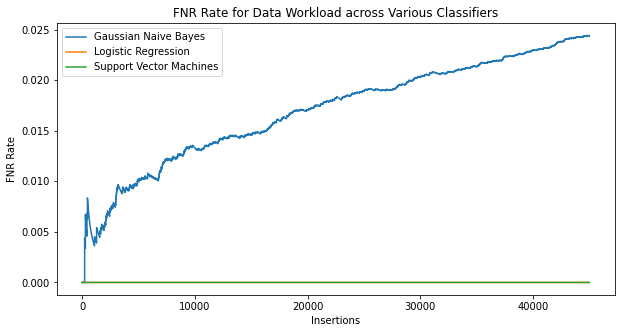

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("FNR Rate for Data Workload across Various Classifiers")
plt.plot(fn_rates_models[0])
plt.plot(fn_rates_models[1])
plt.plot(fn_rates_models[2])

plt.legend(models.keys())
plt.xlabel("Insertions")
plt.ylabel("FNR Rate")
plt.show()  

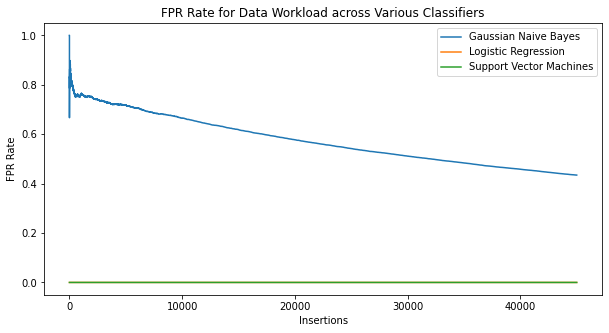

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("FPR Rate for Data Workload across Various Classifiers")
plt.plot(fp_rates_models[0])
plt.plot(fp_rates_models[1])
plt.plot(fp_rates_models[2])
plt.legend(models.keys())
plt.xlabel("Insertions")
plt.ylabel("FPR Rate")
plt.show()  